# LGBM Model

Retrieved from: https://www.kaggle.com/ragnar123/very-fst-model

### Load Libraries

In [5]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import dask_xgboost as xgb
import dask.dataframe as dd
from sklearn import preprocessing, metrics
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
import gc
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Load and Preprocess Data

In [6]:
# Function to reduce memory to increase performance to decrease run time.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# Function to read the data and merge it (ignoring some columns).

def read_data():
    print('Reading files...')
    calendar = pd.read_csv('calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv('sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv('sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv('sample_submission.csv')
    return calendar, sell_prices, sales_train_validation, submission

# Function to merge and melt the four dataframes together.
def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 55000000, merge = False):
    
    # Melt sales data, get it ready for training.
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    # Seperate test dataframes.
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # Change column names.
    test1.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 
                      'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
    
    # Get product table.
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # Merge with product table.
    test1 = test1.merge(product, how = 'left', on = 'id')
    test2 = test2.merge(product, how = 'left', on = 'id')
    
    # Melt the test dataframes.
    test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis = 0)
    
    del sales_train_validation, test1, test2
    
    # Get only a sample for fst training.
    data = data.loc[nrows:]
    
    # Drop some calendar features.
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    
    # Delete test2 for now.
    data = data[data['part'] != 'test2']
    
    if merge:
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day'], inplace = True, axis = 1)
        # Get the sell price data.
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    gc.collect()
    
    return data
        
calendar, sell_prices, sales_train_validation, submission = read_data()
data = melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 27500000, merge = True)
gc.collect()

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to 3226.27 Mb (9.4% reduction)
Our final dataset to train has 31681090 rows and 18 columns


7

In [7]:
# Transform data for lgbm model.
def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
    
    encoder = preprocessing.LabelEncoder()
    data['id_encode'] = encoder.fit_transform(data['id'])
    
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

data = transform(data)
gc.collect()


7

In [8]:
# Function to do feature engineering.
def simple_fe(data):
    
    # Demand features.
    data['lag_t28'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    data['lag_t29'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(29))
    data['lag_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(30))
    data['rolling_mean_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    data['rolling_std_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    data['rolling_mean_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    data['rolling_mean_t90'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    data['rolling_mean_t180'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    data['rolling_std_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
    
    # Price features.
    data['lag_price_t1'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
    data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
    data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
    data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
    data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)
    
    # Time features.
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['week'] = data['date'].dt.week
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    
    return data

data = simple_fe(data)
data = reduce_mem_usage(data)
gc.collect()

Mem. usage decreased to 2568.14 Mb (58.9% reduction)


111

In [9]:
# Create x and y variables for lgbm model.
x = data[data['date'] <= '2016-04-24']
y = x.sort_values('date')['demand']
test = data[(data['date'] > '2016-04-24')]
x = x.sort_values('date')
test = test.sort_values('date')
del data

In [10]:
# Cross validation with 3 folds.
n_fold = 3 
folds = TimeSeriesSplit(n_splits=n_fold)

### LightGBM Model

In [11]:
# Parameters for lgbm model.
params = {'num_leaves': 555,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'regression',
          'max_depth': -1,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 222,
         }

In [12]:
# Running the lgbm model with RMSE evaluation metrics.
columns = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'year', 'month', 'week', 'day', 'dayofweek', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t30', 'rolling_mean_t90', 
            'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30']
splits = folds.split(x, y)
y_preds = np.zeros(test.shape[0])
y_oof = np.zeros(x.shape[0])
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
mean_score = []
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = x[columns].iloc[train_index], x[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    clf = lgb.train(params, dtrain, 2500, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=100)
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
    y_oof[valid_index] = y_pred_valid
    val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, y_valid))
    print(f'val rmse score is {val_score}')
    mean_score.append(val_score)
    y_preds += clf.predict(test[columns], num_iteration=clf.best_iteration)/n_fold
    del X_train, X_valid, y_train, y_valid
    gc.collect()
print('mean rmse score over folds is',np.mean(mean_score))
test['demand'] = y_preds

Fold: 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3.49298	valid_1's rmse: 3.0439
[200]	training's rmse: 3.12241	valid_1's rmse: 2.70715
[300]	training's rmse: 2.92076	valid_1's rmse: 2.5591
[400]	training's rmse: 2.81338	valid_1's rmse: 2.4917
[500]	training's rmse: 2.7374	valid_1's rmse: 2.45977
[600]	training's rmse: 2.68321	valid_1's rmse: 2.44428
[700]	training's rmse: 2.64118	valid_1's rmse: 2.43582
[800]	training's rmse: 2.6077	valid_1's rmse: 2.43206
[900]	training's rmse: 2.57645	valid_1's rmse: 2.43067
Early stopping, best iteration is:
[879]	training's rmse: 2.58312	valid_1's rmse: 2.4302
val rmse score is 2.430199768347135
Fold: 2
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3.23723	valid_1's rmse: 2.87286
[200]	training's rmse: 2.86907	valid_1's rmse: 2.56752
[300]	training's rmse: 2.6844	valid_1's rmse: 2.42999
[400]	training's rmse: 2.58899	valid_1's rmse: 2.36913
[500]	training's rmse: 2.529

### Feature Importance for LightGBM

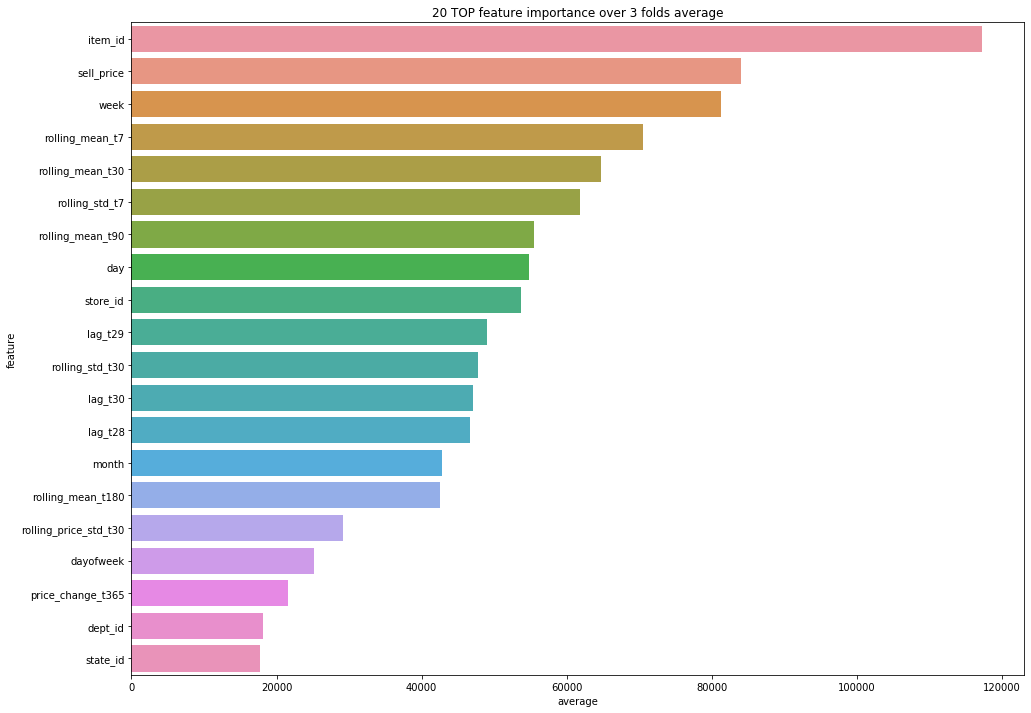

In [15]:
import seaborn as sns
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('lgb_feature_importances.csv')

plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature');
plt.title('20 TOP feature importance over {} folds average'.format(folds.n_splits));

The light GBM model performed fairly well with an RMSE over the folds is approximately 2.3.  I can see from the relative feature importance that the top 3 features were item_id, sell_price, and week.  I think item_id and sell_price makes sense to be the top features for the forecast because the forecast will depend on the items and price of the items.  Week also makes sense because the forecast depends on time parameters to make a forecast, so having a time parameter in the top three relative important features is logical.